# Object Detection with Pre-trained Models
In this notebook, we explore object detection using a pre-trained model from PyTorch's `torchvision` library. We will:
1. Load a pre-trained Faster R-CNN model.
2. Run it on test images.
3. Visualize the predictions.
4. Optionally, fine-tune the model on custom data.

## Setup and Libraries
First, we'll import the necessary libraries and set up the environment.

In [17]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

## Load Pre-trained Faster R-CNN Model
We use a Faster R-CNN model pre-trained on the COCO dataset. This model can detect 80 classes of objects.

R-CNN  <a href='https://arxiv.org/pdf/1311.2524'> paper </a>

In [18]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A',
    'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
    'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut',
    'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'TV', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock',
    'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

def get_label_name(label_id):
    if label_id < len(COCO_INSTANCE_CATEGORY_NAMES):
        return COCO_INSTANCE_CATEGORY_NAMES[label_id]
    return "Unknown"

In [19]:
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## Preprocess the Input Image
We need to preprocess the image before feeding it to the model. This includes resizing, normalization, and converting to a tensor.

In [20]:
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)  # Add batch dimension

## Perform Object Detection
We pass the preprocessed image to the model to get predictions.

In [21]:
def detect_objects(model, image_tensor, confidence_threshold=0.5):
    with torch.no_grad():
        predictions = model(image_tensor)
    
    # Filter out low-confidence predictions
    boxes, labels, scores = [], [], []
    for box, label, score in zip(predictions[0]['boxes'], predictions[0]['labels'], predictions[0]['scores']):
        if score > confidence_threshold:
            boxes.append(box)
            labels.append(label)
            scores.append(score)
    return boxes, labels, scores

## Visualize the Results
We draw the detected bounding boxes and class labels on the image.

In [22]:
def visualize_detections(image_path, boxes, labels, scores):
    image = cv2.imread(image_path)
    for box, label, score in zip(boxes, labels, scores):
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        text = f"Label: {label}, Score: {score:.2f}"
        cv2.putText(image, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    
    plt.figure(figsize=(20, 20))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

## Run the Pipeline
Let's test the pipeline with an example image.

In [39]:
%%time

image_path = 'dirtbike.jpg'  
image_tensor = preprocess_image(image_path)
boxes, labels, scores = detect_objects(model, image_tensor)

CPU times: user 4.01 s, sys: 4.22 s, total: 8.23 s
Wall time: 1.17 s


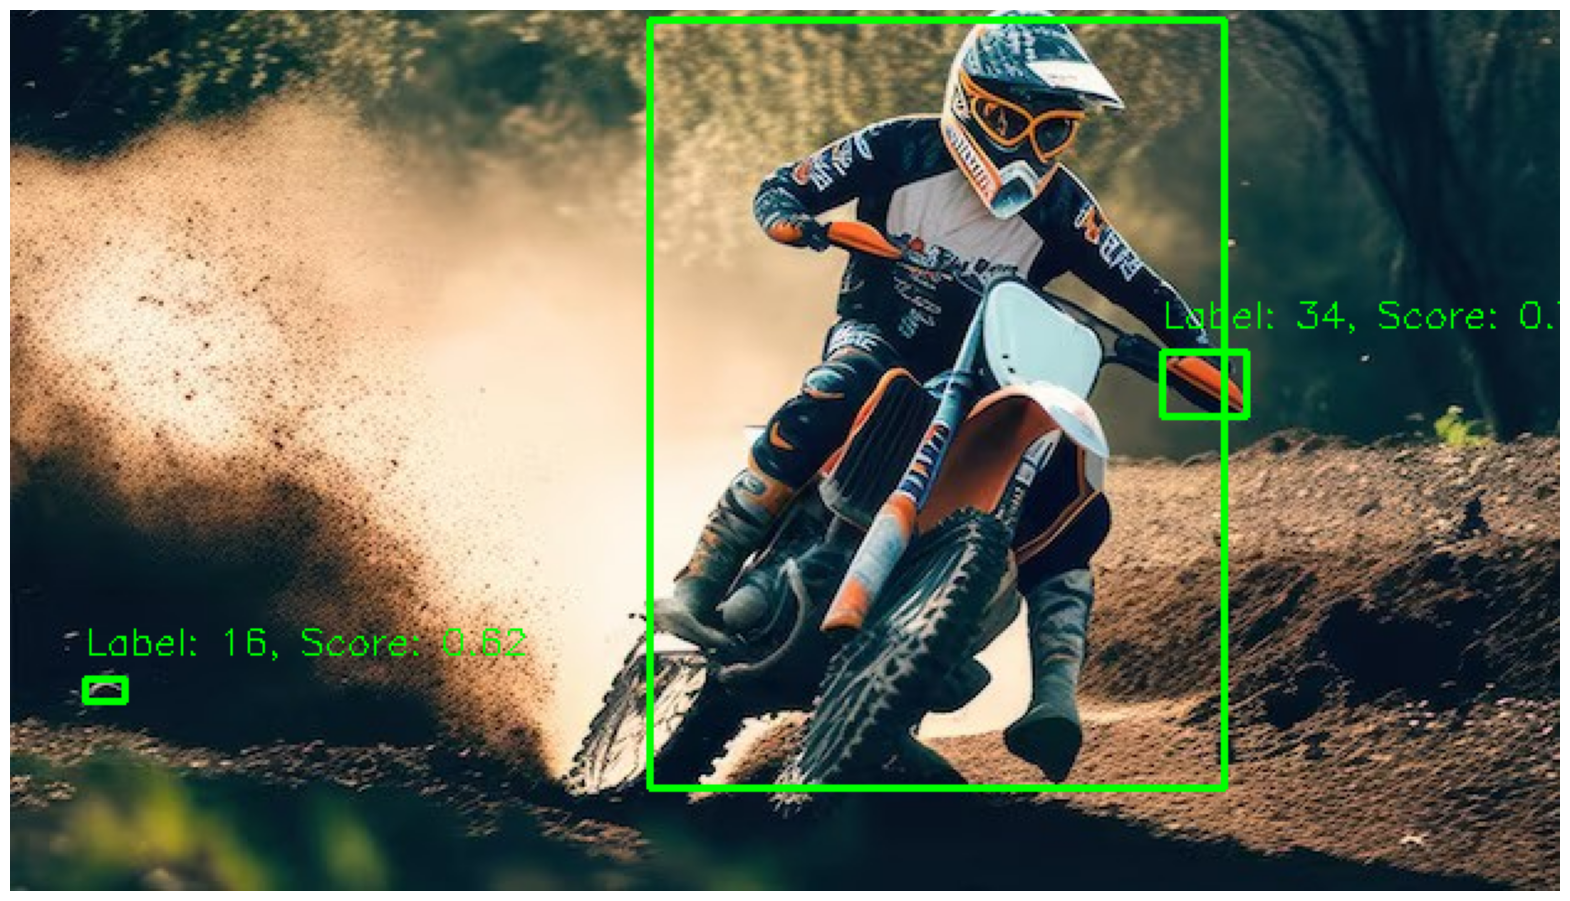

In [40]:
visualize_detections(image_path, boxes, labels, scores)

In [41]:
labels

[tensor(1), tensor(34), tensor(16)]

In [38]:
get_label_name(86)

'vase'

In [45]:
for label, score in zip(labels, scores):
    print(f"Detected: {get_label_name(label)} with confidence {score:.2f}")

Detected: person with confidence 1.00
Detected: frisbee with confidence 0.78
Detected: bird with confidence 0.62


In [49]:
%%time

image_path = 'piano.jpg' 
image_tensor = preprocess_image(image_path)
boxes, labels, scores = detect_objects(model, image_tensor)

CPU times: user 3.21 s, sys: 2.56 s, total: 5.76 s
Wall time: 776 ms


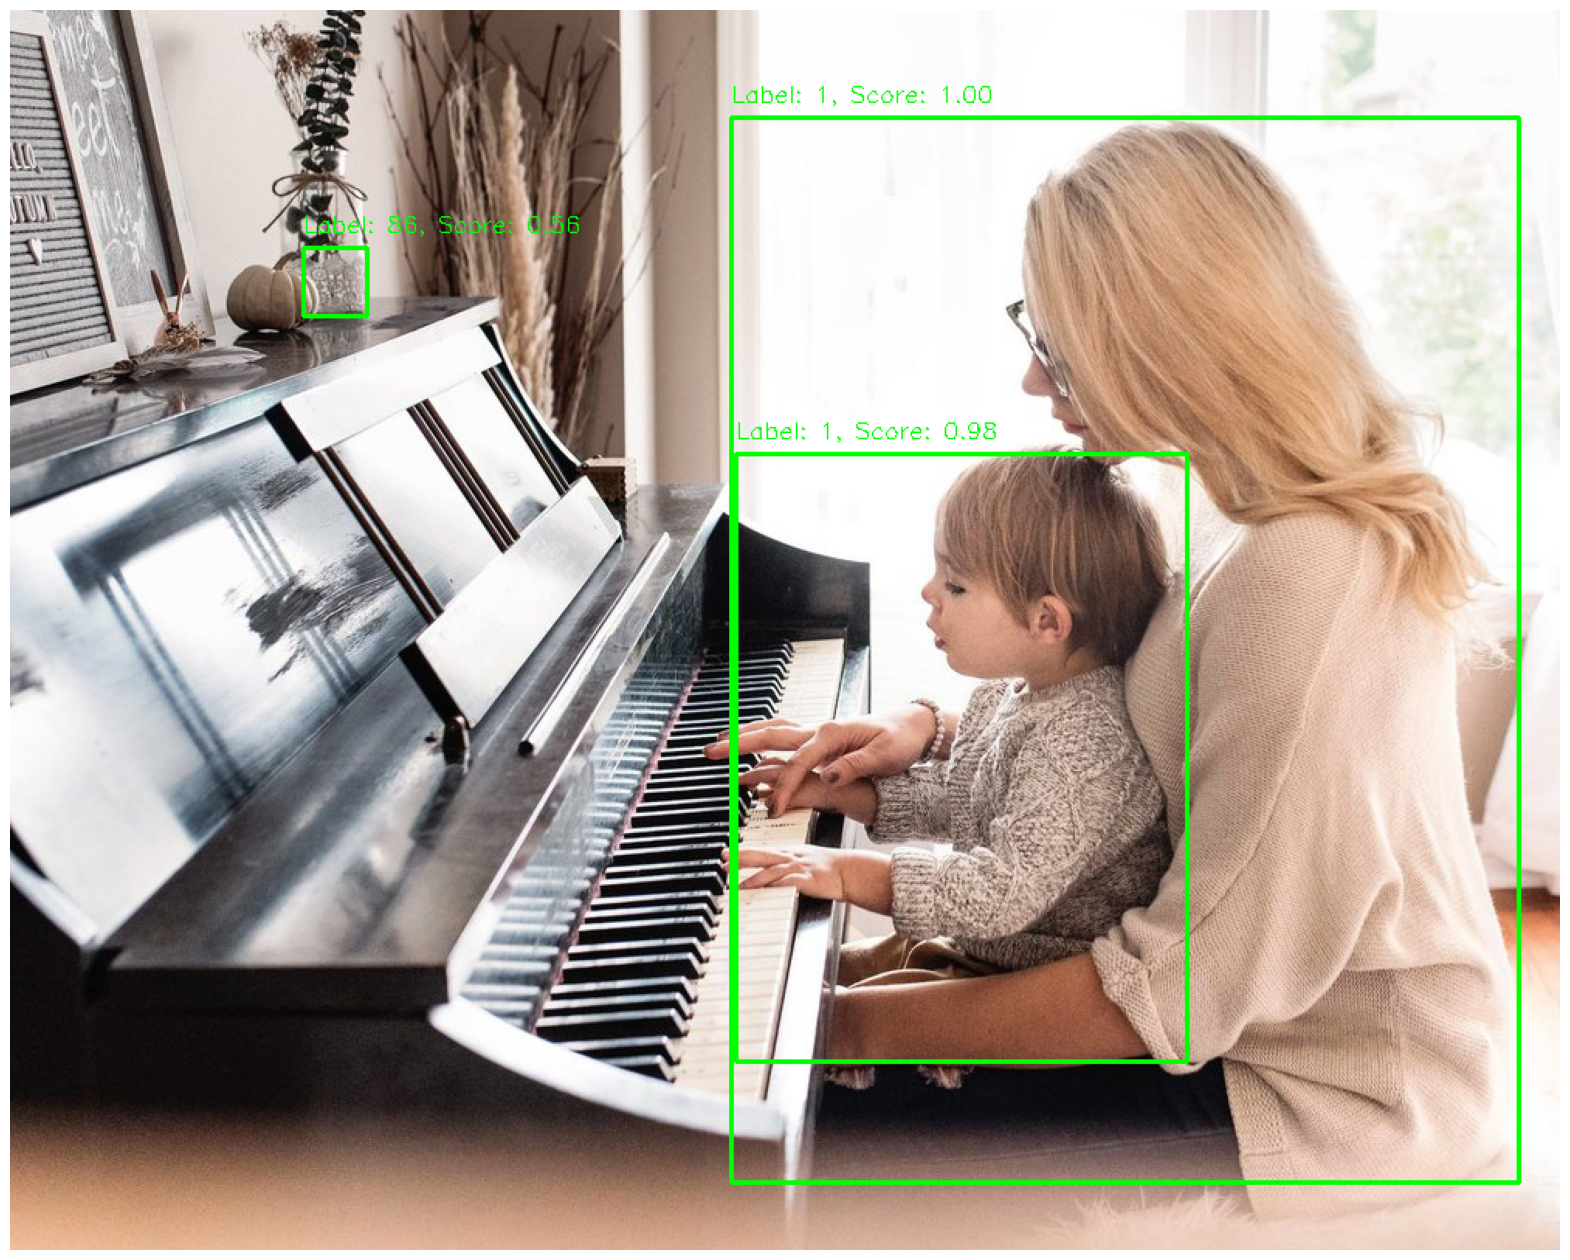

In [ ]:
visualize_detections(image_path, boxes, labels, scores)

In [52]:
for label, score in zip(labels, scores):
    print(f"Detected: {get_label_name(label)} with confidence {score:.2f}")

Detected: person with confidence 1.00
Detected: person with confidence 0.98
Detected: vase with confidence 0.56
